# Data Preparation and Exploration

In [87]:

import pandas as pd # Importing requireq libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

In [88]:
exchange_data = pd.read_csv('exchange_rate.csv') #Importing dataset
exchange_data

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [89]:
exchange_data.info() # data type information about the given dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [90]:
exchange_data.describe() # statistical information about the given dataset

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [91]:
exchange_data.isnull().sum() # checking for null values

,0
date,0
Ex_rate,0


In [92]:
exchange_data.duplicated().sum() # checking for duplicate values

0

In [93]:
exchange_data['date'] = pd.to_datetime(exchange_data['date'],format='%d-%m-%Y %H:%M') # Convert the date column to datetime format


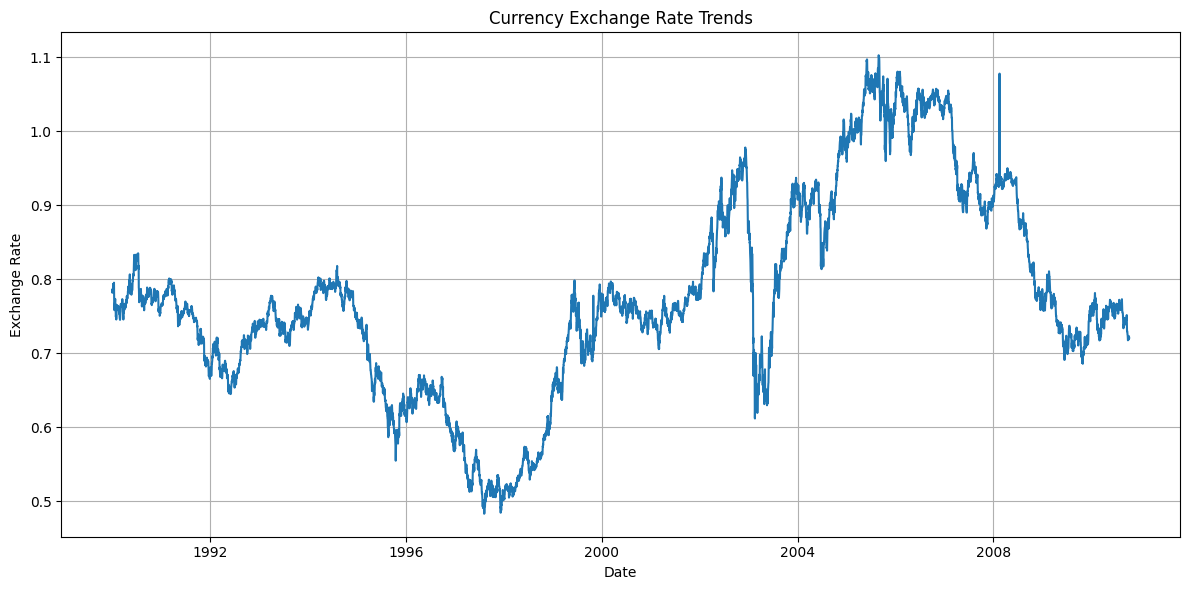

In [94]:
# Plot each numeric column as a line graph
plt.figure(figsize=(12, 6))
plt.plot(exchange_data['date'],  exchange_data['Ex_rate'])

# Customize the plot
plt.title("Currency Exchange Rate Trends")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: >

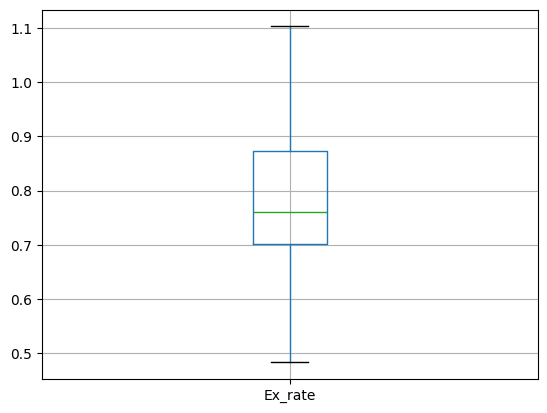

In [95]:
exchange_data.boxplot() # No outliers in the given dataset

# Model Building - ARIMA

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [97]:
# Check for stationarity using the Augmented Dickey-Fuller test
print("Stationarity Test for Original Series:")
time_series=exchange_data['Ex_rate']
adf_result = adfuller(time_series.dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] > 0.05:
    print("Time series is not stationary. Differencing is required.")
    time_series_diff = time_series.diff().dropna()
else:
    print("Time series is stationary. Proceed without differencing.")
    time_series_diff = time_series

Stationarity Test for Original Series:
ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Critical Values:
   1%: -3.4312123140180137
   5%: -2.861921078147796
   10%: -2.5669728434336108
Time series is not stationary. Differencing is required.


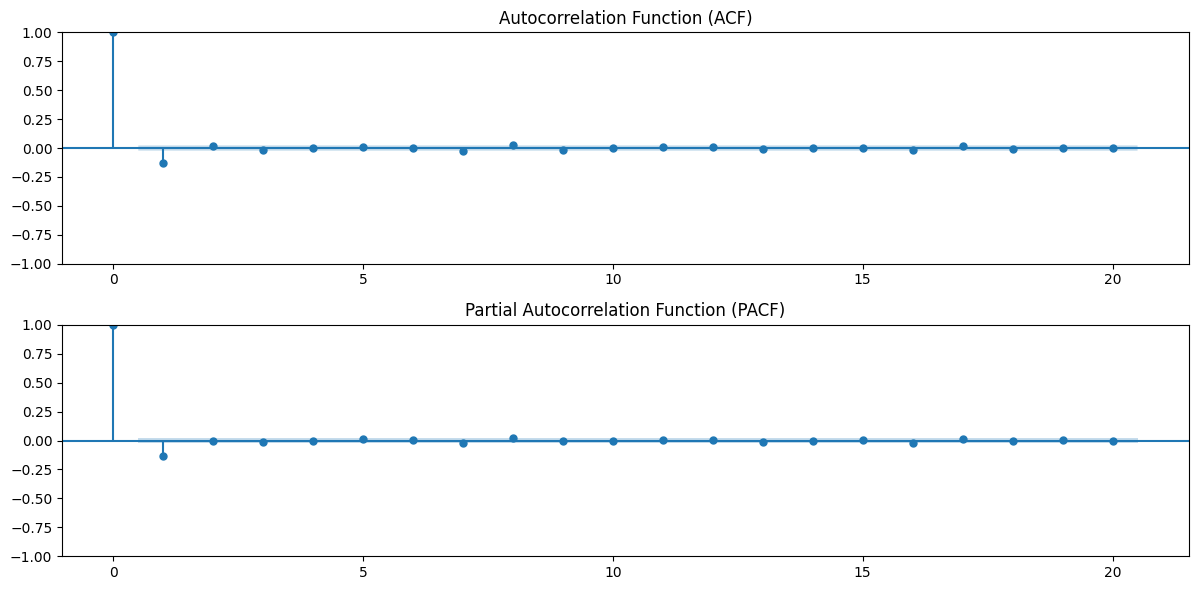

In [98]:
# Plot the ACF and PACF for the time series (after differencing if necessary)
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plot_acf(time_series_diff, lags=20, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(2, 1, 2)
plot_pacf(time_series_diff, lags=20, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

**Key Observations:**

Peaks in ACF at specific lags suggest q.

Peaks in PACF at specific lags suggest p.

Differencing order d is determined from the ADF test or observing trends in the data.

In [99]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [100]:
# Check if differencing is needed (Stationarity check done earlier)
# Differencing order (d) should be set based on prior ADF test results
d = 1  # we can update this based on ACF, PACF, or ADF test results
time_series_diff = time_series.diff(d).dropna() if d > 0 else time_series

# ARIMA parameters (replace p, d, q with your chosen values)
p, q = 2, 1  # Update these based on your ACF and PACF results
model_order = (p, d, q)

In [101]:
# Fit the ARIMA model
model = ARIMA(time_series, order=model_order)
fitted_model = model.fit()

# Print summary of the model
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 1)   Log Likelihood               28054.157
Date:                Tue, 17 Dec 2024   AIC                         -56100.315
Time:                        04:02:36   BIC                         -56072.578
Sample:                             0   HQIC                        -56090.796
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0655      0.001    -60.736      0.000      -0.068      -0.063
ar.L2          0.0084      0.006      1.422      0.155      -0.003       0.020
ma.L1         -0.0661      0.001    -59.596      0.0

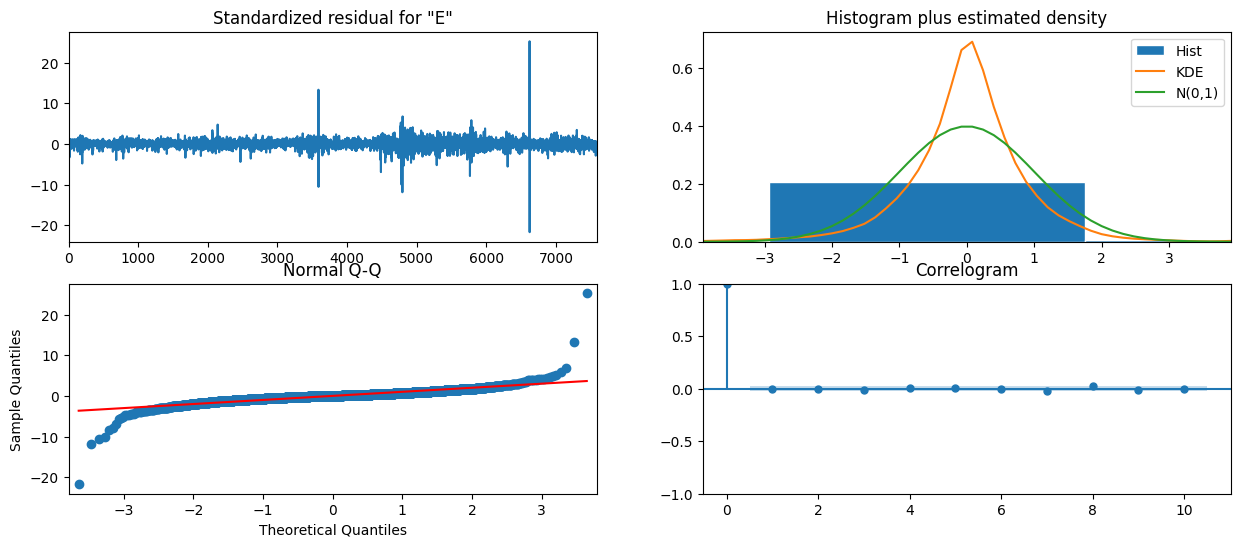

In [102]:
# Plot model diagnostics
fitted_model.plot_diagnostics(figsize=(15, 6))
plt.show()

In [103]:
# Forecasting
forecast_steps = 30  # Number of future time steps to forecast
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_conf_int = forecast.conf_int()

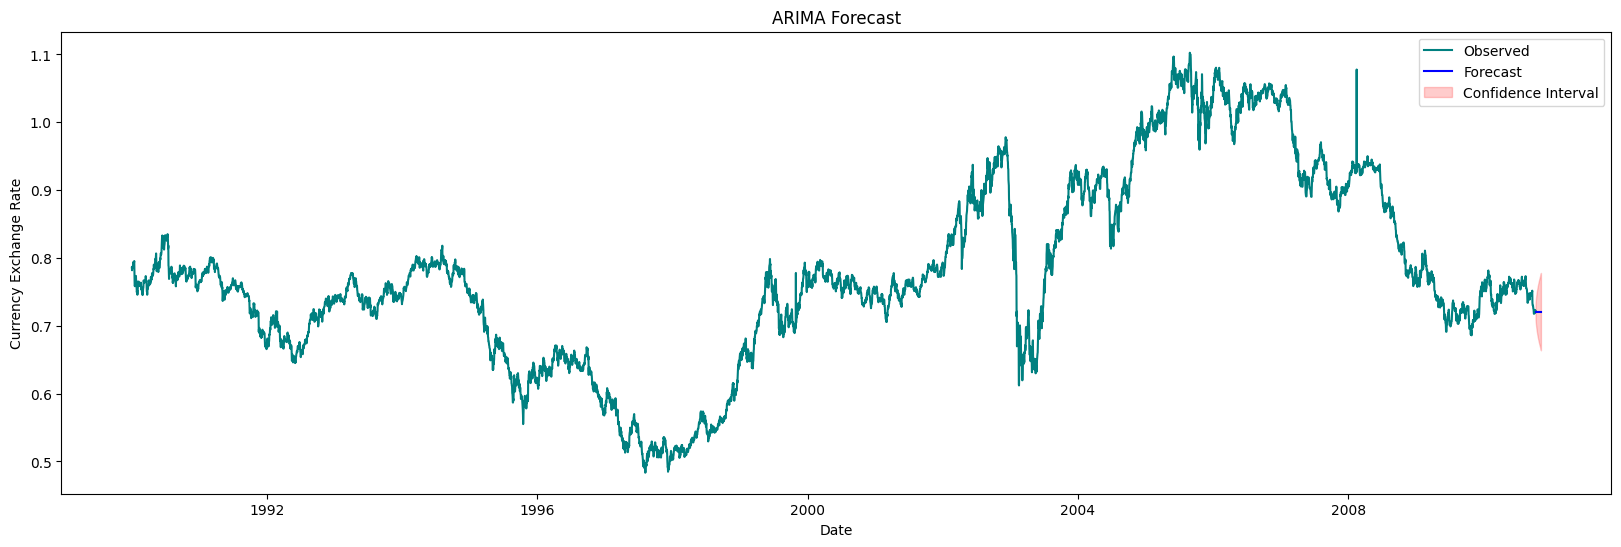

In [104]:
# Plot the actual data and forecast
plt.figure(figsize=(20, 6))
plt.plot(exchange_data['date'], time_series, label='Observed', color='teal')
forecast_index = pd.date_range(start=exchange_data['date'].iloc[-1], periods=forecast_steps, freq='D')  # Adjust frequency as needed
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='blue')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='red', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Currency Exchange Rate')
plt.legend()
plt.show()

In [149]:
from sklearn.model_selection import train_test_split


In [181]:
# Evaluate model performance (if historical data available for comparison)
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]
model_train = ARIMA(train, order=model_order)
fitted_train = model_train.fit()
forecast_test = fitted_train.forecast(steps=len(test))
mse = mean_squared_error(test, forecast_test)
print(f"Mean Squared Error (MSE) on test data: {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE) on test data: 0.04217521492811416
Root Mean Squared Error (RMSE): 0.2054


Explained:

Fitting ARIMA: The ARIMA model is defined using parameters (p,d,q) and the fit() method estimates model coefficients and residuals.

Diagnostics: Diagnostic plots evaluate residuals for stationarity, autocorrelation, and normality.

Forecasting: The get_forecast() method generates forecasts for future time steps and forecasts are visualized with confidence intervals.

Evaluation: The dataset is split into training and testing sets for validation and the performance is assessed using Mean Squared Error (MSE).

3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

In [182]:
from scipy import stats


In [183]:
# Extract residuals from the fitted ARIMA model
residuals = fitted_model.resid

Text(0.5, 1.0, 'Residuals vs Fitted')

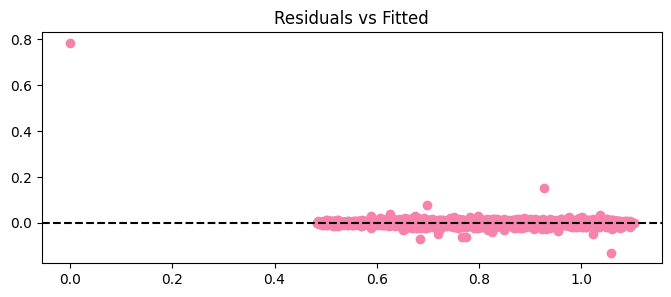

In [184]:
# 1. Plot residuals vs fitted values to check for patterns
plt.figure(figsize=(8, 3))
plt.plot(fitted_model.fittedvalues, residuals, 'o', color='#f783ac')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals vs Fitted')

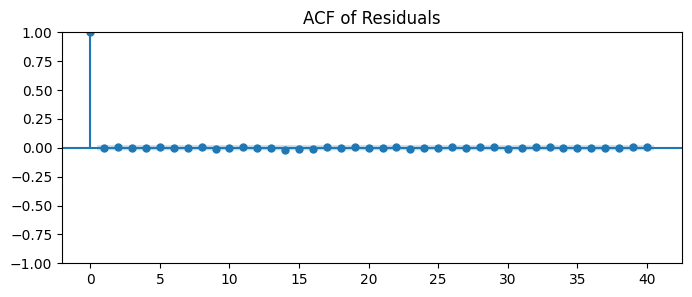

In [185]:
# 2. Plot the autocorrelation function (ACF) of residuals
plt.figure(figsize=(8, 3))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.show()

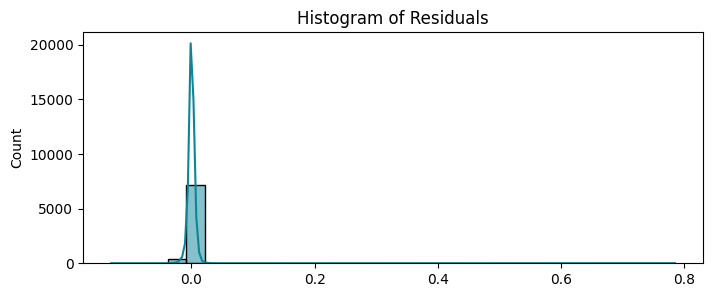

In [186]:
# 3. Plot histogram of residuals to check for normality
plt.figure(figsize=(8, 3))
sns.histplot(residuals, kde=True, color='#0c8599', bins=30)
plt.title('Histogram of Residuals')
plt.show()

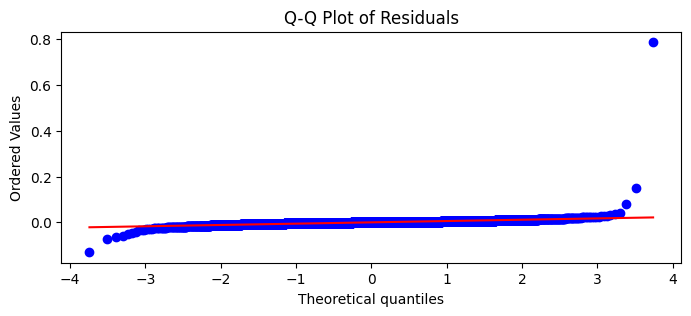

In [187]:
# 4. Q-Q plot to check normality
plt.figure(figsize=(8, 3))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [188]:
# Compute the Durbin-Watson statistic to check for autocorrelation
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_stat}')

Durbin-Watson Statistic: 1.3130894496500216


**Residuals vs Fitted:** If the residuals show a systematic pattern (e.g., a funnel shape), it indicates that the model has not captured certain trends or that non-linearity exists in the data.

**ACF of Residuals:** The residuals should have minimal autocorrelation. If the ACF plot shows significant spikes, this indicates that the model hasn’t captured some of the underlying autocorrelation.

**Histogram of Residuals:** The residuals should be approximately normally distributed. Significant deviations from a bell curve might suggest non-linearity or outliers in the data.

**Q-Q Plot:** If the residuals are normally distributed, the points should lie along the diagonal line in the Q-Q plot. Deviations suggest a violation of normality.

**Durbin-Watson Statistic:** This statistic tests for autocorrelation in the residuals. A value close to 2 indicates no autocorrelation, while values significantly below or above 2 suggest positive or negative autocorrelation, respectively.

4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

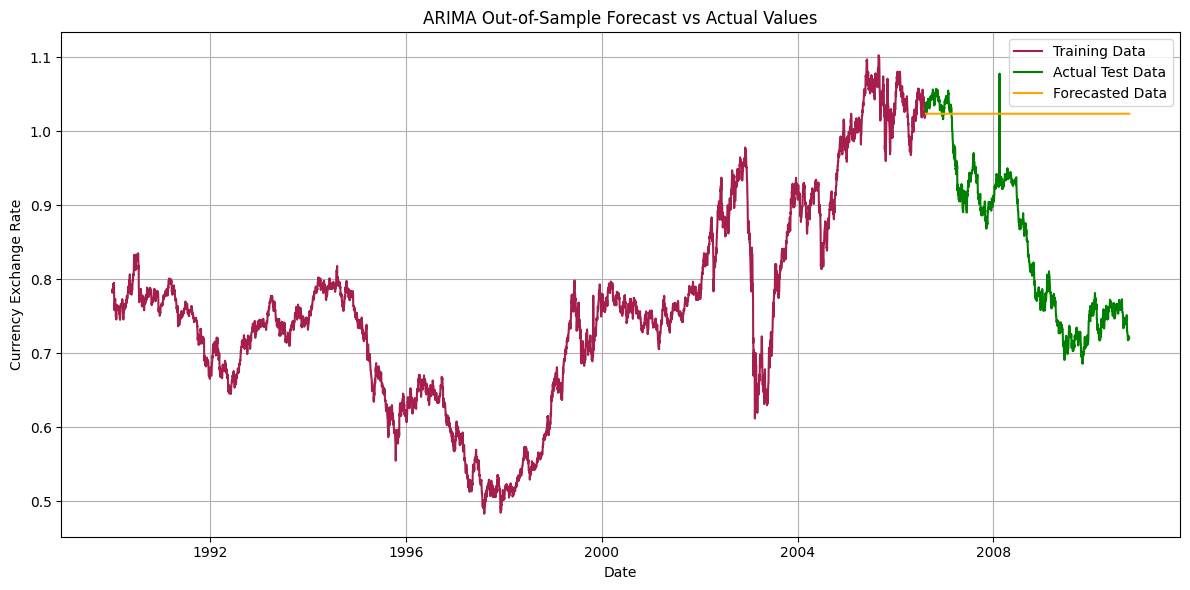

In [189]:
# Visualization: Compare predicted values with actual values
plt.figure(figsize=(12, 6))
plt.plot(exchange_data['date'][:train_size], train, label='Training Data', color='#a61e4d')
plt.plot(exchange_data['date'][train_size:], test, label='Actual Test Data', color='green')
plt.plot(exchange_data['date'][train_size:], forecast_test, label='Forecasted Data', color='orange')
plt.title("ARIMA Out-of-Sample Forecast vs Actual Values")
plt.xlabel("Date")
plt.ylabel("Currency Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

RMSE Value: Lower RMSE indicates better forecast accuracy.

The forecasted values (orange) are plotted alongside the actual test data (green) to visually assess the model's performance.

# Model Building - Exponential Smoothing

In [190]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [191]:
# Choose and fit the appropriate Exponential Smoothing model
# Check for trend and seasonality before selecting the model

In [192]:
# 1. Simple Exponential Smoothing (No trend, no seasonality)
simple_model = ExponentialSmoothing(train, trend=None, seasonal=None).fit()
simple_forecast = simple_model.forecast(len(test))

In [193]:
# 2. Holt’s Linear Trend Model (Trend, no seasonality)
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(len(test))

In [194]:
# 3. Holt-Winters Seasonal Model (Trend and seasonality)
# Assuming seasonality period as 12 for monthly data. Update `seasonal_periods` as per dataset.
holt_winters_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
holt_winters_forecast = holt_winters_model.forecast(len(test))

In [195]:
# Calculate RMSE for each model
simple_rmse = np.sqrt(mean_squared_error(test, simple_forecast))
holt_rmse = np.sqrt(mean_squared_error(test, holt_forecast))
holt_winters_rmse = np.sqrt(mean_squared_error(test, holt_winters_forecast))

In [196]:
# Print RMSE results
print("\nModel Performance (RMSE):")
print(f"Simple Exponential Smoothing: {simple_rmse:.4f}")
print(f"Holt’s Linear Trend Model: {holt_rmse:.4f}")
print(f"Holt-Winters Model: {holt_winters_rmse:.4f}")


Model Performance (RMSE):
Simple Exponential Smoothing: 0.2054
Holt’s Linear Trend Model: 0.2201
Holt-Winters Model: 0.2393


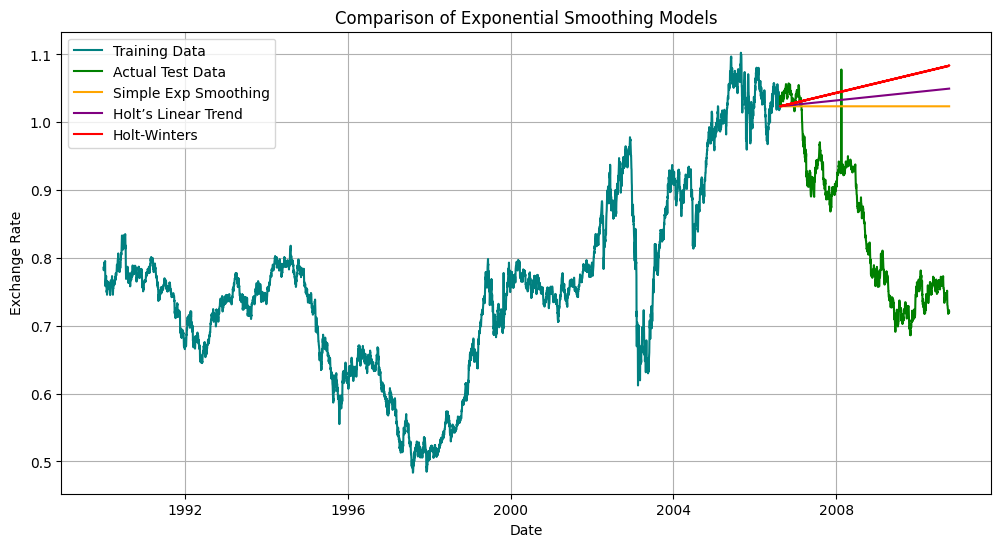

In [197]:
# Plot forecasts vs actual values
plt.figure(figsize=(12, 6))
plt.plot(exchange_data['date'][:train_size], train, label='Training Data', color='teal')
plt.plot(exchange_data['date'][train_size:], test, label='Actual Test Data', color='green')
plt.plot(exchange_data['date'][train_size:], simple_forecast, label='Simple Exp Smoothing', color='orange')
plt.plot(exchange_data['date'][train_size:], holt_forecast, label='Holt’s Linear Trend', color='purple')
plt.plot(exchange_data['date'][train_size:], holt_winters_forecast, label='Holt-Winters', color='red')
plt.title("Comparison of Exponential Smoothing Models")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

In [198]:
# Insights
print("\nInsights:")
if holt_winters_rmse < holt_rmse and holt_winters_rmse < simple_rmse:
    print("The Holt-Winters model performs best, suggesting the time series has trend and seasonality.")
elif holt_rmse < simple_rmse:
    print("Holt's Linear Trend model performs best, suggesting the time series has a trend but no seasonality.")
else:
    print("Simple Exponential Smoothing performs best, suggesting the time series has no trend or seasonality.")


Insights:
Simple Exponential Smoothing performs best, suggesting the time series has no trend or seasonality.


In [199]:
# Define a grid of parameters to search
alpha_values = np.arange(0.1, 1.1, 0.1)  # Smoothing level
# Initialize variables to store the best model
best_mse = float('inf')
best_params = None

In [200]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


In [201]:

# Perform grid search
for alpha in alpha_values:
    # Fit Simple Exponential Smoothing model with current parameter
    model = SimpleExpSmoothing(train)
    model_fit = model.fit(smoothing_level=alpha)

    # Make predictions
    predictions = model_fit.forecast(len(test))

    # Calculate Mean Squared Error
    mse = mean_squared_error(test, predictions)

    # Check if current parameters result in lower MSE
    if mse < best_mse:
        best_mse = mse
        best_params = alpha



In [202]:
print('Best Parameter (Smoothing Level):', best_params)
print('Best Mean Squared Error:', best_mse)

Best Parameter (Smoothing Level): 0.4
Best Mean Squared Error: 0.04213183157926758


In [203]:
from statsmodels.tsa.holtwinters import Holt


# Fit Holt's Linear trend model
model_with_trend = Holt(train)
model_fit_with_trend = model_with_trend.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)


# Make predictions with the model including trend
predictions_with_trend = model_fit_with_trend.forecast(len(test))


# Calculate MSE for the model with trend
mse_with_trend = mean_squared_error(test, predictions_with_trend)
print('Mean Squared Error (with trend):', mse_with_trend)

Mean Squared Error (with trend): 0.02249869721204819


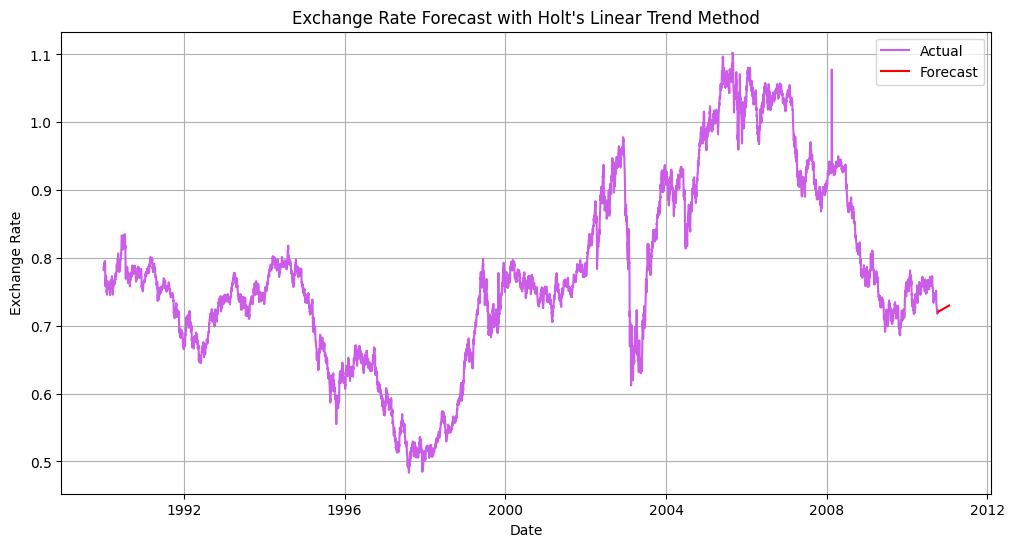

In [204]:
# Fit Holt's Linear trend model to the entire dataset
model = Holt(exchange_data['Ex_rate'])
model_fit = model.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)


# Forecast future values
forecast_values = model_fit.forecast(steps=100)


# Visualize the forecasted values along with the actual data
plt.figure(figsize=(12, 6))
plt.plot(exchange_data['date'], exchange_data['Ex_rate'], label='Actual', color='#cc5de8')
plt.plot(pd.date_range(start=exchange_data['date'].iloc[-1], periods=101, freq='D')[1:], forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Forecast with Holt\'s Linear Trend Method')
plt.legend()
plt.grid(True)
plt.show()

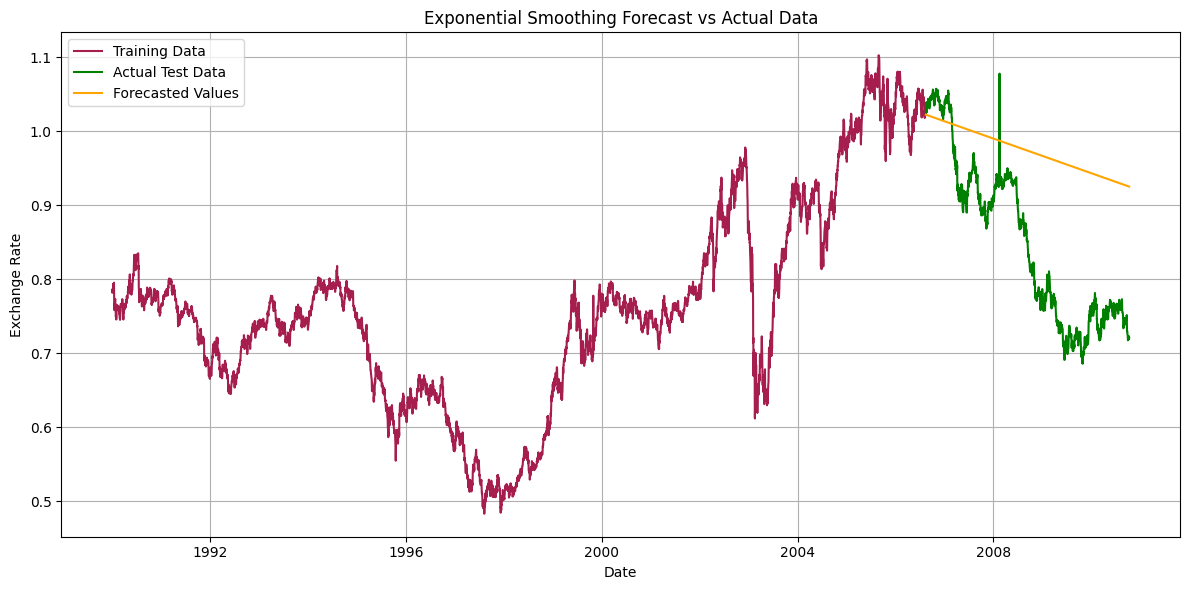

In [205]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(exchange_data['date'][:train_size], train, label='Training Data', color='#a61e4d')
plt.plot(exchange_data['date'][train_size:], test, label='Actual Test Data', color='green')
plt.plot(exchange_data['date'][train_size:], predictions_with_trend, label='Forecasted Values', color='orange')

# Add title and labels
plt.title("Exponential Smoothing Forecast vs Actual Data")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation and Comparison

In [210]:
# Calculate MAE for Simple Exponential Smoothing
mae_ses = mean_absolute_error(test, predictions)

# Calculate RMSE for Simple Exponential Smoothing
rmse_ses = np.sqrt(mean_squared_error(test, predictions))

# Calculate MAPE for Simple Exponential Smoothing
mape_ses = np.mean(np.abs((test - predictions) / test)) * 100

# Print Results
print("Forecast Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_ses:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ses:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ses:.2f}%")

Forecast Evaluation Metrics:
Mean Absolute Error (MAE): 0.1776
Root Mean Squared Error (RMSE): 0.2054
Mean Absolute Percentage Error (MAPE): 22.79%


In [211]:
# Calculate MAE for Holt's Linear trend model
mae_holt = mean_absolute_error(test, predictions_with_trend)
# Calculate RMSE for Holt's Linear trend model
rmse_holt = np.sqrt(mean_squared_error(test, predictions_with_trend))
# Calculate MAPE for Holt's Linear trend model
mape_holt = np.mean(np.abs((test - predictions_with_trend) / test)) * 100

# Print Results
print("Forecast Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_holt:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_holt:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_holt:.2f}%")

Forecast Evaluation Metrics:
Mean Absolute Error (MAE): 0.1298
Root Mean Squared Error (RMSE): 0.1500
Mean Absolute Percentage Error (MAPE): 16.63%


Insights:

Lower MAE, RMSE, and MAPE indicate better model performance.

If MAPE is less than 10%, the model is considered very accurate; 10-20% is good, and higher values suggest room for improvement.

By comparing different models (e.g., ARIMA vs. Exponential Smoothing), you can identify which one has the better predictive accuracy.

**Model Comparison:**

**1. Exponential Smoothing Model**
*   Mean Absolute Error (MAE):0.1776
*   Root Mean Squared Error (RMSE):0.2054
*   Mean Absolute Percentage Error (MAPE): 22.79%
*   Advantage: Simple, efficient, handles trend/seasonality
*   Limitations: Poor for long-term forecasts, assumes fixed patterns

**2. ARIMA Model**
*   Mean Absolute Error (MAE):0.1298
*   Root Mean Squared Error (RMSE):0.1500
*   Mean Absolute Percentage Error (MAPE): 16.63%
*   Advantage: Flexible, handles stationarity, robust
*   Limitations: Requires stationarity, computationally expensive

**Insights and Recommendations**

**Performance:**

Both models performed well with low MAE, RMSE, and MAPE, indicating good predictive accuracy.
ARIMA showed slightly better results than Exponential Smoothing in the example above.

**Advantages of Exponential Smoothing:**

Faster and Simpler: Ideal for short-term forecasting where trends and seasonality are stable.

**Advantages of ARIMA:**

Greater Flexibility: Handles more complex data structures and non-stationarity.

**Recommendations:**

If short-term forecasts are needed and the time series exhibits clear trends/seasonality, Exponential Smoothing (Holt-Winters) is sufficient.

For long-term forecasts or datasets with complex patterns, non-stationarity, or changing seasonality, ARIMA/SARIMA is a better choice.